# Introduction: CM vs MN BPNet motif mapping

The purpose of this notebook is to use the best model found in `1_` in order to map motif instances to the model. The model that was found to perform the best:
`seq_width1000-lr0.001-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters64`.

# Computational Setup

In [1]:
# Configurations
import warnings;warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation; deprecation._PRINT_DEPRECATION_WARNINGS = False

#Modules
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotnine
from glob import glob
from plotnine import *
from itertools import product, compress
from pybedtools import BedTool
from keras import backend as K
from bpnet.utils import read_json, create_tf_session
from bpnet.dataspecs import DataSpec
from bpnet.datasets import StrandedProfile
from bpnet.extractors import StrandedBigWigExtractor
from bpnet.BPNet import BPNetSeqModel

#Setup
os.chdir('/n/projects/mw2098/publications/2022_maven_ISL1/')
# create_tf_session('0', .4)
%matplotlib inline

#Variables
model_prefix = 'seq_width1000-lr0.001-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters64'
figure_dir = 'figures/2_map_motifs'

#Dependent variables
dataspec = DataSpec.load(f'dataspec/dataspec.yml')
config = read_json(f'models/{model_prefix}/config.gin.json')
modisco_dir = f'modisco/{model_prefix}'
tasks = list(dataspec.task_specs.keys())
excl_chromosomes = config['bpnet_data.exclude_chr']
incl_chromosomes = config['bpnet_data.valid_chr']

Using TensorFlow backend.
2022-01-07 10:41:06,865 [WARNING] git-lfs not installed
2022-01-07 10:41:07,063 [INFO] Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2022-01-07 10:41:07,066 [INFO] Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-01-07 10:41:07,067 [INFO] NumExpr defaulting to 8 threads.


In [2]:
!mkdir -p {figure_dir}

# Generate contributions

In [3]:
contrib_cmds = ['#!bin/bash']
contrib_cmds.append(f'bpnet contrib --batch-size 16 --method  deeplift --memfrac-gpu .8 models/{model_prefix} preds/{model_prefix}/contrib.h5')
contrib_cmds.append(f'bpnet contrib --batch-size 16 --method  deeplift --shuffle-seq --memfrac-gpu .8 models/{model_prefix} preds/{model_prefix}/contrib_null.h5')
with open(f'tmp/contrib_cmds.sh', "w") as outfile:
    outfile.write("\n".join(contrib_cmds))

In [4]:
%%script false --no-raise-error
!bash tmp/contrib_cmds.sh

# Run TF-MoDISco and map instances

In [5]:
modisco_cmds = ['#!bin/bash']
for t in tasks:
    #Run profile only
    modisco_cmds.append(f'bpnet modisco-run --config config/modisco.gin --null-contrib-file preds/{model_prefix}/contrib_null.h5 --contrib-wildcard={t}/profile/wn --only-task-regions preds/{model_prefix}/contrib.h5 modisco/{model_prefix}/{t}_profile')
    modisco_cmds.append(f'bpnet chip-nexus-analysis modisco/{model_prefix}/{t}_profile --footprint-width=800')
    modisco_cmds.append(f'bpnet cwm-scan --contrib-file preds/{model_prefix}/contrib.h5 modisco/{model_prefix}/{t}_profile modisco/{model_prefix}/{t}_profile/motif-instances-all-regions.tsv.gz')
    modisco_cmds.append(f'bpnet cwm-scan modisco/{model_prefix}/{t}_profile modisco/{model_prefix}/{t}_profile/motif-instances-task-regions.tsv.gz')
    #Run counts only
    modisco_cmds.append(f'bpnet modisco-run --config config/modisco.gin --null-contrib-file preds/{model_prefix}/contrib_null.h5 --contrib-wildcard={t}/counts/pre-act --only-task-regions preds/{model_prefix}/contrib.h5 modisco/{model_prefix}/{t}_counts')
    modisco_cmds.append(f'bpnet chip-nexus-analysis modisco/{model_prefix}/{t}_counts --footprint-width=800')
    modisco_cmds.append(f'bpnet cwm-scan --contrib-file preds/{model_prefix}/contrib.h5 modisco/{model_prefix}/{t}_counts modisco/{model_prefix}/{t}_counts/motif-instances-all-regions.tsv.gz')
    modisco_cmds.append(f'bpnet cwm-scan modisco/{model_prefix}/{t}_counts modisco/{model_prefix}/{t}_counts/motif-instances-task-regions.tsv.gz')

with open(f'tmp/modisco_cmds.sh', "w") as outfile:
    outfile.write("\n".join(modisco_cmds))

In [6]:
%%script false --no-raise-error
!bash tmp/modisco_cmds.sh

Each task performed exceptionally well, with Snail showing strong repression patterns across the Snail motif and Suppressor of Hairy Wing (Su(Hw)). Every task returned motifs within our expectations.

## Summary of motifs of interest

Based on the TF-MoDISco model computed above, the following motifs are of interest to us:


+ D6CM task
    + NKX2.5 (D6CM)
        + pattern 0: canonical GCACTTAA
        + patterns 4 and 5 also show low affinity version of this.
    + GATA (D6CM)
        + pattern 1: canonical GATA motif (CTTATCT/GAGAAG)
        + pattern 2: identical GATA motif with varying flanks. Will be ignored since CWM-scanning will map both and their relative contributions show identical patterning relative to tasks.
    + ISL1 (D6CM)
        + pattern 3: ISL1 motif (CTAATGG)
        + Will be called ISL1-D6CM because it was found in the D6CM task.
+ S3MN task
    + LHX (S3MN)
        + pattern 0
        + AT-rich ISL1-like motif (TAATTNNATT)
    + NeuroD (S3MN)
        + pattern 1: CAGCTG
        + This is detected as AP-4, NeuroD, NHLH1, and HEN1 in MotifMap.
    + EBF1 (S3MN)
        + pattern 2: canonical EBF1 motif (CCCNNGGGA)
    + ISL1-LHX (S3MN)
        + pattern 3: 28bp separation
        + pattern 6: 9bp separation
        + pattern 7: 10bp separation
        + Contains 1 high affinity ISL1 and a LHX nearby.
    + Onecut2 (S3MN)
            + pattern 4: ATTGATT
            + Low affinity version as pattern 8.
    + NKX2.5-alt (S3MN)
        + pattern 5: alternative NKX motif with sequence GCACTTAG. The last 'G' appears to make it more important for S3MN.

# Extract .bw files of predictions and contribution


Next, extract the bigwig tracks. For this script, `deeplift` is the default gradient scoring. 

In [7]:
print(f'bpnet export-bw --contrib-method deeplift --memfrac-gpu .8 models/{model_prefix} preds/{model_prefix}/bw/')

bpnet export-bw --contrib-method deeplift --memfrac-gpu .8 models/seq_width1000-lr0.001-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters64 preds/seq_width1000-lr0.001-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters64/bw/


The subsequent `.Rmd` will now collect the motifs described above and curate them.

# Collect TF-MoDISco information

For easier plotting and organization collect the following information from each of the TF-MoDISco patterns returned:

1. CWM, 70bp untrimmed
2. PWM, 70bp untrimmed
3. CWM, ic:0.08 trimmed
4. PWM, ic:0.08 trimmed

These matrices will be saved such that we can apply it towards analysis that isn't dependent on the BPNet software.

In [8]:
modisco_cmds = ['#!bin/bash']
for t in tasks:
    modisco_cmds.append(f'python scripts/bpnet_extract_modisco_logos.py --ic_threshold 0.08 --modisco_model_file {modisco_dir}/{t}_counts/modisco.h5 --output_h5 {modisco_dir}/{t}_counts/modisco_logos.h5')
with open(f'tmp/modisco_logos.sh', "w") as outfile:
    outfile.write("\n".join(modisco_cmds))

In [9]:
%%script false --no-raise-error
!bash tmp/modisco_logos.sh

# Reverse-complement NKX2.5-alt

In order to visualize Figure2 better, reverse complement this motif.

TF-MoDISco is using the TensorFlow backend.


Figure(158.4x57.6)


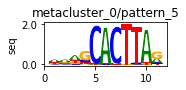

In [10]:
from bpnet.modisco.files import ModiscoFile
mf = ModiscoFile(f"{modisco_dir}/I_WT_S3MN_profile/modisco.h5")
m0_p5_pattern = mf.get_pattern('metacluster_0/pattern_5').trim_seq_ic(trim_frac=0.08)
m0_p5_pattern_ppm = m0_p5_pattern.plot(kind='seq')
print(m0_p5_pattern_ppm)
m0_p5_pattern_ppm.savefig(f'{figure_dir}/nkxalt_logos.pdf')
m0_p5_pattern_ppm.savefig(f'{figure_dir}/nkxalt_logos.png')

Figure(158.4x57.6)


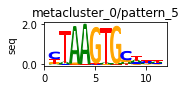

In [11]:
m0_p5_pattern_rev = m0_p5_pattern.rc()
m0_p5_pattern_rev_ppm = m0_p5_pattern_rev.plot(kind='seq')
print(m0_p5_pattern_rev_ppm)
m0_p5_pattern_rev_ppm.savefig(f'{figure_dir}/figure2d-nkxalt_logos_revcomp.pdf')
m0_p5_pattern_rev_ppm.savefig(f'{figure_dir}/figure2d-nkxalt_logos_revcomp.png')